# Convolutional Neural Networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## Data Loading

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28 * 28) / 255
X_test = X_test.astype(np.float32).reshape(-1, 28 * 28) / 255
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[: 5000], X_train[5000:]
y_valid, y_train = y_train[: 5000], y_train[5000:]

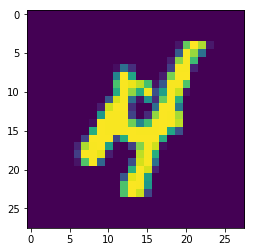

In [3]:
plt.imshow(X_train[777].reshape(28, 28));

## Defining Parameters

In [4]:
height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = 'SAME'

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = 'SAME'

pool3_fmaps = conv2_fmaps

n_fc1 = 64
n_outputs = 10

## Defining Placeholders

In [ ]:
tf.reset_default_graph()

with tf.name_scope('inputs'):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name='X')
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name='y')

## Defining Layers

In [ ]:
with tf.name_scope('conv'):
    conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                             strides=conv1_stride, padding=conv1_pad,
                             activation=tf.nn.relu, name='conv1')
    conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                             strides=conv2_stride, padding=conv2_pad,
                             activation=tf.nn.relu, name='conv2')

In [ ]:
with tf.name_scope('pool3'):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7])

In [ ]:
with tf.name_scope('fc1'):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name='fc1')

In [ ]:
with tf.name_scope('output'):
    logits = tf.layers.dense(fc1, n_outputs, name='output')
    Y_proba = tf.nn.softmax(logits, name='Y_proba')

## Defining Loss Function

In [ ]:
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)

## Training Model

In [ ]:
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

## Evaluating Model

In [ ]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

## Running Model

In [ ]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [ ]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, 'Last batch accuracy:', acc_batch, 'Test accuracy:', acc_test)

        save_path = saver.save(sess, './Models/tf_cnn_example.ckpt')

## Predicting Data

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, save_path)
    X_new_scaled = X_test[: 20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)

In [ ]:
print('Predicted classes:', y_pred)
print('Actual classes:   ', y_test[: 20])